In [50]:
from collections import defaultdict, Counter
import mynn
import json
import numpy as np
import time
import mygrad as mg
import gensim
from gensim.models.keyedvectors import KeyedVectors
from sklearn.decomposition import TruncatedSVD
from mynn.layers.dense import dense
from mynn.optimizers.adam import Adam
import matplotlib.pyplot as plt
%matplotlib notebook

from mygrad.nnet.losses.margin_ranking_loss import margin_ranking_loss
from mygrad.nnet.initializers import glorot_normal

import pickle

import re, string
punc_regex = re.compile('[{}]'.format(re.escape(string.punctuation)))


In [ ]:
path = r"./glove.6B.50d.txt.w2v"
glove = KeyedVectors.load_word2vec_format(path, binary=False)

In [2]:
with open('resnet18_features.pkl', mode="rb") as open_file:
    resnet = pickle.load(open_file)

In [64]:
class COCOMappings:
    def __init__(self, glove):
        with open(r'./captions_train2014.json') as json_file:
            self.data = json.load(json_file)
            
        self.glove = glove
            
        self.caption_ids_to_captions = {cap['id']: cap['caption'] for cap in self.data['annotations']}
        self.image_ids_to_urls = {img['id']: img['coco_url'] for img in self.data['images']}
        
        self.img_ids = tuple(cap['image_id'] for cap in self.data['annotations'])
        self.caption_ids = tuple(cap['id'] for cap in self.data['annotations'])
        self.captions = tuple(cap['caption'] for cap in self.data['annotations'])
        
        self.caption_ids_to_embs = self.caption_id_to_emb()
        self.image_id_to_caption_id = self.generate_image_to_caption_id()
    
    def generate_image_to_caption_id(self):
        image_id_to_caption_ids_dict = {}
        
        for cap_dict in self.data['annotations']:
            if cap_dict['image_id'] in image_id_to_caption_ids_dict:
                image_id_to_caption_ids_dict[cap_dict['image_id']].append(cap_dict['id'])
            else:
                image_id_to_caption_ids_dict[cap_dict['image_id']] = [cap_dict['id']]
                
        return image_id_to_caption_ids_dict
        
    def tokenize(self, corpus):
        return punc_regex.sub('', corpus).lower().split()

    def to_df(self, captions):
        
        counter = Counter()
        for caption in captions:
            counter.update(set(self.tokenize(caption)))
        return dict(counter)
    
    
    def to_idf(self, captions):
        """ 
        Given the vocabulary, and the word-counts for each document, computes
        the inverse document frequency (IDF) for each term in the vocabulary.

        Parameters
        ----------
        vocab : Sequence[str]
            Ordered list of words that we care about.

        counters : Iterable[collections.Counter]
            The word -> count mapping for each document.

        Returns
        -------
        numpy.ndarray
            An array whose entries correspond to those in `vocab`, storing
            the IDF for each term `t`: 
                               log10(N / nt)
            Where `N` is the number of documents, and `nt` is the number of 
            documents in which the term `t` occurs.
        """
        vishnu = self.to_df(captions)
        return {word : np.log10(len(captions)/cnt + 1) for word, cnt in vishnu.items()}
    
    def normalize(self, array):
        #sqrroot(sum(vectorsquared))
        return (np.sum(array ** 2)) ** 0.5
        
        
    def caption_to_emb(self, caption, idfs):
        vishnu = sum(self.glove[word] * idfs[word] for word in self.tokenize(caption) if word in self.glove)
        return vishnu/self.normalize(vishnu)
    
    def caption_id_to_emb(self):
        idfs = self.to_idf(self.captions)
        return {caption_id : self.caption_to_emb(self.caption_ids_to_captions[caption_id], idfs) for caption_id in self.caption_ids}
    def save_database(self, file_path='model.pkl'):
        """Pickles database dictionary and saves at specified directory
        
        Parameters
        ----------
        file_path : optional, string
                    String representing the file path to where the pickled dictionary should be stored
                    
        Returns
        -------
        Completion Message : string
                                Message that save is completed
        """
        
        with open(file_path, mode="wb") as opened_file:
            pickle.dump(self.parameters, opened_file)
        return "Save Complete"
    
def load_database(self, file_path='model.pkl'):
        """Loads pickled database dictionary from specified directory
        
        Parameters
        ----------
        file_path : optional, string
                    String representing file path to where the pickled dictionary is stored
        """
        with open(file_path, mode="rb") as opened_file:
            self.parameters = pickle.load(opened_file)
        return "database loaded! :D"

In [39]:
def generate_triples(data, model, num_captions, trips_per_cap):
    triples = []
    for i in range(num_captions):
        img_id = None
        while img_id not in resnet: img_id = np.random.choice(data)
        cap_id = np.random.choice(model.image_id_to_caption_id[img_id])
        cap_emb = model.caption_ids_to_embs[cap_id]
        for n in range(trips_per_cap):
            bad_img_id = generate_bad_img(img_id, cap_emb, model, data)
            triples.append((img_id, cap_id, bad_img_id))
    triples = np.array(triples)
    np.random.shuffle(triples)
    return triples

In [40]:
def generate_bad_img(img_id, cap_emb, model, data):
    captions = []
    images = []
    for i in range(25):
        id_choice = img_id
        while id_choice == img_id or id_choice not in resnet: id_choice = np.random.choice(data)
        images.append(id_choice)
        captions.append(np.random.choice(model.image_id_to_caption_id[id_choice]))
    dots = np.zeros(25)
    for index, cap in enumerate(captions):
        emb = model.caption_ids_to_embs[cap]
        dots[index] = np.matmul(emb, cap_emb)
    max_index = np.argmax(dots)
    #bad_caption_id = captions[max_index]
    bad_img_id = images[max_index]
    return bad_img_id

In [6]:
def get_caption_embeddings(img_ids, dictionary):
    """
    Parameters
    ----------
    Sequence[int]
        N image IDs 
    dictionary : Dict[int, np.ndarray]
        img-ID -> shape-(50,) glove embedding vectors
    
    Returns
    -------
    shape-(N, 50)
        An array of the corresponding glove embedding vectors
    """
    vectors = np.zeros((len(img_ids), 50), dtype=np.float32)
    for n, _id in enumerate(img_ids):
        vectors[n] = dictionary[_id]
    return vectors

In [7]:
def get_image_embeddings(img_ids, resnet18_features):
    """
    Parameters
    ----------
    Sequence[int]
        N image IDs 
    resnet18_features : Dict[int, np.ndarray]
        img-ID -> shape-(512,) resnet vector
    
    Returns
    -------
    shape-(N, 512)
        An array of the corresponding resnet vectors
    """
    vectors = np.zeros((len(img_ids), 512), dtype=np.float32)
    for n, _id in enumerate(img_ids):
        vectors[n] = resnet18_features[_id]
    return vectors

In [8]:
class LinearEncoder:
    def __init__(self, d_input, d_output):
        """ This initializes all of the layers in our model, and sets them
        as attributes of the model.
        
        Parameters
        ----------
        d_input : int
            The size of the inputs.
            
        d_output : int
            The size of the outputs (i.e., the reduced dimensionality).
        """
        
        self.encoder = dense(d_input, d_output, weight_initializer=glorot_normal)
        
    def __call__(self, x):
        '''Passes data as input to our model, performing a "forward-pass".
        
        This allows us to conveniently initialize a model `m` and then send data through it
        to be classified by calling `m(x)`.
        
        Parameters
        ----------
        x : Union[numpy.ndarray, mygrad.Tensor], shape=(M, D_full)
            A batch of data consisting of M pieces of data,
            each with a dimentionality of D_full.
            
        Returns
        -------
        mygrad.Tensor, shape=(M, D_full)
            The model's prediction for each of the M pieces of data.
        '''
        
        return self.encoder(x) / mg.sqrt(mg.sum(x ** 2, axis = 1, keepdims = True)) 
        
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model """
        
        return self.encoder.parameters

In [9]:
def accuracy(predictions, truth):
    """
    Returns the mean classification accuracy for a batch of predictions.
    
    Parameters
    ----------
    predictions : Union[numpy.ndarray, mg.Tensor], shape=(N, 2)
        The scores for 2 classes, for a batch of N data points
        
    truth : numpy.ndarray, shape=(N,)
        The true labels for each datum in the batch: each label is an
        integer in [0, 1]
    
    Returns
    -------
    float
    """
   
    if isinstance(predictions, mg.Tensor):
        predictions = predictions.data
    return np.mean(np.argmax(predictions, axis=1) == truth)

In [65]:
coco = COCOMappings(glove)
total_imgs = len(coco.img_ids)
train_range = 4*total_imgs//5
ids = np.array(coco.img_ids)
np.random.shuffle(ids)
train = ids[:train_range]
test = ids[train_range:]
model = LinearEncoder(d_input=512, d_output=50)
optimizer = Adam(model.parameters)

<IPython.core.display.Javascript object>


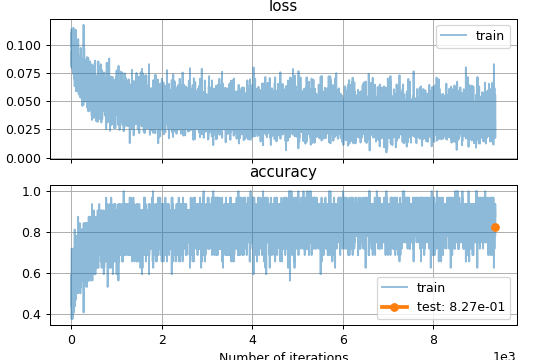

In [66]:
from noggin import create_plot
plotter, fig, ax = create_plot(["loss", "accuracy"])

In [41]:
triples_train = generate_triples(train, coco, 30000, 10)
triples_test = generate_triples(test, coco, 10000, 10)

In [22]:
print(triples_train.shape)

(3000, 3)


In [67]:
batch_size = 32
for epoch_cnt in range(1):
    
    # Create the indices to index into each image of your training data
    # e.g. `array([0, 1, ..., 9999])`, and then shuffle those indices.
    # We will use this to draw random batches of data

    
    for batch_cnt in range(0, len(triples_train), batch_size):
        # Index into `x_train` to get your batch of M images.
        # Make sure that this is a randomly-sampled batch

        batch = triples_train[batch_cnt:batch_cnt + batch_size]  # random batch of our training data

        
        # compute the predictions for this batch by calling on model
        good_img_ids, good_caption_ids, bad_img_ids = list(zip(*batch))
        predictions = model(get_image_embeddings(good_img_ids, resnet))
        bad_img_embeds = model(get_image_embeddings(bad_img_ids, resnet))
        good_cap_embeds = get_caption_embeddings(good_caption_ids, coco.caption_ids_to_embs)

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        s_good = mg.sum(predictions * good_cap_embeds, axis=1)
        s_bad = mg.sum(bad_img_embeds * good_cap_embeds, axis=1)
        loss = margin_ranking_loss(s_good, s_bad, y=1, margin=0.1) 
        

        # compute the accuracy between the prediction and the truth 
        acc = np.mean(s_good > s_bad)  # <COGLINE>
        

        # back-propagate through your computational graph through your loss
        loss.backward()  # <COGLINE>
        

        # execute gradient-descent by calling step() of optim
        optimizer.step()  # <COGLINE>
        
        
        # null your gradients
        loss.null_gradients()  # <COGLINE>
        

        plotter.set_train_batch({"loss" : loss.item(),
                                 "accuracy" : acc},
                                 batch_size=batch_size)
    
    # After each epoch we will evaluate how well our model is performing
    # on data from cifar10 *that it has never "seen" before*. This is our
    # "test" data. The measured accuracy of our model here is our best 
    # estimate for how our model will perform in the real world 
    # (on 32x32 RGB images of things in this class)
    
    
    for batch_cnt in range(0, len(triples_test), batch_size):
        # Index into `x_train` to get your batch of M images.
        # Make sure that this is a randomly-sampled batch

        batch = triples_test[batch_cnt:batch_cnt + batch_size]  # random batch of our training data

        
        # compute the predictions for this batch by calling on model
        good_img_ids, good_caption_ids, bad_img_ids = list(zip(*batch))
        predictions = model(get_image_embeddings(good_img_ids, resnet))
        bad_img_embeds = model(get_image_embeddings(bad_img_ids, resnet))
        good_cap_embeds = get_caption_embeddings(good_caption_ids, coco.caption_ids_to_embs)

        # compute the loss associated with our predictions(use softmax_cross_entropy)
        s_good = mg.sum(predictions * good_cap_embeds, axis=1)
        s_bad = mg.sum(bad_img_embeds * good_cap_embeds, axis=1)
        #loss = margin_ranking_loss(s_good, s_bad, y=1, margin=0.1) 
        test_accuracy = np.mean(s_good > s_bad)
        
        # pass your test-accuracy here; we used the name `test_accuracy`
        plotter.set_test_batch({"accuracy" : test_accuracy}, batch_size=batch_size)
    plotter.set_test_epoch()
    plotter.set_train_epoch()
    print(test_accuracy)

0.875


In [34]:
def save_model(model, path):
        """Path to .npz file where model parameters will be saved."""
        with open(path, "wb") as f:
            np.savez(f, *(x.data for x in model.parameters))

Tensor([ 0.11210952,  0.04283203, -0.04020774, -0.03343286,  0.01957453,
        -0.04585631,  0.02037729,  0.00633401, -0.03665007,  0.13126269,
         0.05586885,  0.00793957, -0.0485589 , -0.02303583,  0.03389621,
        -0.07481416,  0.041896  ,  0.01404783,  0.0860191 ,  0.0736204 ,
        -0.008607  ,  0.01595681,  0.06470338,  0.02921922,  0.04544584,
         0.05614189,  0.09397859,  0.17944363,  0.03584863,  0.02808025,
        -0.02003735,  0.00501574], dtype=float32)


In [68]:
save_model(model, "params.pkl")

AttributeError: 'COCOMappings' object has no attribute 'parameters'